The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==1.0.0-alpha0


# Working with Sequences
:label:`sec_sequence`



Up until now, we've focused on models whose inputs
consisted of a single feature vector $\mathbf{x} \in \mathbb{R}^d$.
The main change of perspective when developing models
capable of processing sequences is that we now
focus on inputs that consist of an ordered list
of feature vectors $\mathbf{x}_1, \dots, \mathbf{x}_T$,
where each feature vector $x_t$
indexed by a sequence step $t \in \mathbb{Z}^+$
lies in $\mathbb{R}^d$.

Some datasets consist of a single massive sequence.
Consider, for example, the extremely long streams
of sensor readings that might be available to climate scientists.
In such cases, we might create training datasets
by randomly sampling subsequences of some predetermined length.
More often, our data arrive as a collection of sequences.
Consider the following examples:
(i) a collection of documents,
each represented as its own sequence of words,
and each having its own length $T_i$;
(ii) sequence representation of
patient stays in the hospital,
where each stay consists of a number of events
and the sequence length depends roughly
on the length of the stay.


Previously, when dealing with individual inputs,
we assumed that they were sampled independently
from the same underlying distribution $P(X)$.
While we still assume that entire sequences
(e.g., entire documents or patient trajectories)
are sampled independently,
we cannot assume that the data arriving
at each sequence step are independent of each other.
For example, what words are likely to appear later in a document
depends heavily on what words occurred earlier in the document.
What medicine a patient is likely to receive
on the 10th day of a hospital visit
depends heavily on what transpired
in the previous nine days.

This should come as no surprise.
If we didn't believe that the elements in a sequence were related,
we wouldn't have bothered to model them as a sequence in the first place.
Consider the usefulness of the auto-fill features
that are popular on search tools and modern email clients.
They are useful precisely because it is often possible
to predict (imperfectly, but better than random guessing)
what likely continuations of a sequence might be,
given some initial prefix.
For most sequence models,
we don't require independence,
or even stationarity, of our sequences.
Instead, we require only that
the sequences themselves are sampled
from some fixed underlying distribution
over entire sequences.

This flexible approach, allows for such phenomena
as (i) documents looking significantly different
at the beginning than at the end,
or (ii) patient status evolving either
towards recovery or towards death
over the course of a hospital stay;
and (iii) customer taste evolving in predictable ways
over course of continued interaction with a recommender system.


We sometimes wish to predict a fixed target $y$
given sequentially structured input
(e.g., sentiment classification based on a movie review).
At other times, we wish to predict a sequentially structured target
($y_1, \cdots, y_T$)
given a fixed input (e.g., image captioning).
Still other times, out goal is to predict sequentially structured targets
based on sequentially structured inputs
(e.g., machine translation or video captioning).
Such sequence-to-sequence tasks take two forms:
(a) **aligned:** where the input at each sequence step
aligns with a corresponding target (e.g., part of speech taggin);
(b) **unaligned** where the input and target
do not necessarily exhibit a step-for-step correspondence
(e.g. machine translation).

But before we worry about handling targets of any kind,
we can tackle the most straightforward problem:
unsupervised density modeling (also called *sequence modeling*).
Here, given a collection of sequences,
our goal is to estimate the probability mass function
that tells us how likely we are to see any given sequence,
i.e. $p(\mathbf{x}_1, \cdots, \mathbf{x}_T)$.





## Basic Tools

Before introducing specialized specialized neural networks
designed to handle sequentially structured data,
let's take a look at some actual sequence data
and build up some basic intuitions and statistical tools.
In particular, we will focus on stock price data
from the FTSE 100 index (:numref:`fig_ftse100`).
At each *time step* $t \in \mathbb{Z}^+$, we observe
the price of the index at that time, denoted by $x_t$.


![FTSE 100 index over about 30 years.](../img/ftse100.png)
:width:`400px`
:label:`fig_ftse100`


Now suppose that a trader would like to make short term trades,
strategically getting into or out of the index,
depending on whether they believe
that it will rise or decline
in the subsequent time step.
Absent any other features
(news, financial reporting data, etc),
the only available signal for predicting
the subsequent value is the history of prices to date.




### Autoregressive Models

The trader is thus interested in knowing
the probability distribution $$P(x_t \mid x_{t-1}, \ldots, x_1)$$ over prices that the index might take
in the subsequent time step.
While estimating the entire distribution
over a continuous-valued random variable
can be difficult, the trader would be happy
to focus on a few key statistics of the distribution,
particularly the expected value and the variance.
One simple strategy for estimating the conditional expectation

$$\mathbb{E}[(x_t \mid x_{t-1}, \ldots, x_1)],$$

would be to apply a linear regression model,
(recall :numref:`sec_linear_concise`).
Such models that regress the value of a signal
on the previous values of that same signal
are naturally called *autoregressive models*.
There is just one major problem; the number of inputs,
$x_{t-1}, \ldots, x_1$ varies, depending on $t$.
Namely, the number of inputs increases
with the amount of data that we encounter.
Thus if we want to treat our historical data
as a training set, we are left with the problem
that each example has a different number of features.
Much of what follows in this chapter
will revolve around techniques
for overcoming these challenges
when engaging in such *autoregressive* modeling problems
where the object of interest is
$P(x_t \mid x_{t-1}, \ldots, x_1)$
or some statistic(s) of this distribution.

A few strategies recur frequently.
First, we might believe that although long sequences
$x_{t-1}, \ldots, x_1$ are available,
it may not be necessary
to look back so far in the history
when predicting the near future.
In this case we might content ourselves
to condition on some window of length $\tau$
and only use $x_{t-1}, \ldots, x_{t-\tau}$ observations.
The immediate benefit is that now the number of arguments
is always the same, at least for $t > \tau$.
This allows us to train any linear model or deep network
that requires fixed-length vectors as inputs.
Second, we might develop models that maintain
some summary $h_t$ of the past observations
(see :numref:`fig_sequence-model`)
and at the same time update $h_t$
in addition to the prediction $\hat{x}_t$.
This leads to models that estimate $x_t$
with $\hat{x}_t = P(x_t \mid h_{t})$
and moreover updates of the form
$h_t = g(h_{t-1}, x_{t-1})$.
Since $h_t$ is never observed,
these models are also called
*latent autoregressive models*.

![A latent autoregressive model.](../img/sequence-model.svg)
:label:`fig_sequence-model`

To construct training data from historical data, one
typically creates examples by sampling windows randomly.
In general, we do not expect time to stand still.
However, we often assume that while
the specific values of $x_t$ might change,
the dynamics according to which each subsequent
observation is generated given the previous observations do not.
Statisticians call dynamics that do not change *stationary*.



## Sequence Models

Sometimes, especially when working with language,
we wish to estimate the joint probability
of an entire sequence.
This is a common task when working with sequences
composed of discrete tokens, such as words.
Generally, these estimated functions are called *sequence models*
and for natural language data, they are called *language models*.
The field of sequence modeling has been driven so much by NLP,
that we often describe sequence models as "language models",
even when dealing with non-language data.
Language models prove useful for all sorts of reasons.
Sometimes we want to evaluate the likelihood of sentences.
For example, we might wish to compare
the naturalness of two candidate outputs
generated by a machine translation systems
or by a speech recognition system.
But language modeling gives us not only
the capacity to *evaluate* likelihood,
but the ability to *sample* sequences,
and even to optimize for the most likely sequences.

While language modeling might not look, at first glance,
like an autoregressive problem,
we can reduce language modeling to autogregressive prediction
by decomposing the joint density  of a sequence $p(x_t| x_1, \ldots, x_T)$
into the product of conditional densities
in a left-to-right fashion
by applying the chain rule of probability:

$$P(x_1, \ldots, x_T) = P(x_1) * \prod_{t=2}^T P(x_t \mid x_{t-1}, \ldots, x_1).$$

Note that if we are working with discrete signals like words,
then the autoregressive model must be a probabilistic classifier,
outputting a full probability distribution
over the vocabulary for what word will come next,
given the leftwards context.



### Markov Models
:label:`subsec_markov-models`


Now suppose that we wish to employ the strategy mentioned above,
where we condition only on the $\tau$ previous sequence steps,
i.e., $x_{t-1}, \ldots, x_{t-\tau}$, rather than
the entire sequence history $x_{t-1}, \ldots, x_1$.
Whenever we can throw away the history
beyond the precious $\tau$ steps
without any loss in predictive power,
we say that the sequence satisfies a *Markov condition*,
i.e., *that the future is conditionally independent of the past,
given the recent history*.
When $\tau = 1$, we say that the data is characterized
by a *first-order Markov model*,
and when $\tau = k$, we say that the data is characterized
by a $k$-th order Markov model.
For when the first-order Markov condition holds ($\tau = 1$)
the factorization of our joint probability becomes a product
of probabilities of each word given the previous *word*:

$$P(x_1, \ldots, x_T) = \prod_{t=1}^T P(x_t \mid x_{t-1}) \text{ where } P(x_1 \mid x_0) = P(x_1).$$

We often find it useful to work with models that proceed
as though a Markov condition were satisfied,
even when we know that this is only *approximately* true.
With real text documents we continue to gain information
as we include more and more leftwards context.
But these gains diminish rapidly.
Thus, sometimes we compromise, obviating computational and statistical difficulties
by training models whose validity depends
on a $k$-th order Markov condition.
Even today's massive RNNs- and Transformer-based language models
seldom incorporate more than a thousand words of context.


With discrete data, a true Markov model
simply counts the number of times
that each word has occurred in each context, producing
the relative frequency estimate of $P(x_t \mid x_{t-1})$.
Whenever the data assume only discrete values
(as in language),
the most likely sequence of words can be computed efficiently
using dynamic programming.


### The Order of Decoding

You might be wondering, why did we have to represent
the factorization of a text sequence $P(x_1, \ldots, x_T)$
as a left-to-right chain of conditional probabilities.
Why not right-to-left or some other, seemingly random order?
In principle, there is nothing wrong with unfolding
$P(x_1, \ldots, x_T)$ in reverse order.
The result is a valid factorization:

$$P(x_1, \ldots, x_T) = \prod_{t=T}^1 P(x_t \mid x_{t+1}, \ldots, x_T).$$


However, there are many reasons why factorizing text
in the same directions as we read it
(left-to-right for most languages,
but right-to-left for Arabic and Hebrew)
is preferred for the task of language modeling.
First, this is just a more natural direction for us to think about.
After all we all read text every day,
and this process is guided by our ability
to anticipate what words and phrases
are likely to come next.
Just think of how many times you have completed
someone else's sentence.
Thus, even if we had no other reason to prefer such in-order decodings,
they would be useful if only because we have better intuitions
for what should be likely when predicting in this order.

Second, by factorizing in order,
we can assign probabilities to arbitrarily long sequences
using the same language model.
To convert a probability over steps $1$ through $t$
into one that extends to word $t+1$ we simply
multiply by the conditional probability
of the additional token given the previous ones:
$P(x_{t+1}, \ldots, x_1) = P(x_{t}, \ldots, x_1) \cdot P(x_{t+1} \mid x_{t}, \ldots, x_1)$.

Third, we have stronger predictive models
for predicting adjacent words versus
words at arbitrary other locations.
While all orders of factorization are valid,
they do not necessarily all represent equally easy
predictive modeling problems.
This is true not only for language,
but for other kinds of data as well,
e.g., when the data are causally structured.
For example, we believe that future events cannot influence the past.
Hence, if we change $x_t$, we may be able to influence
what happens for $x_{t+1}$ going forward but not the converse.
That is, if we change $x_t$, the distribution over past events will not change.
In some contexts, this makes it easier to predict $P(x_{t+1} \mid x_t)$
than to predict $P(x_t \mid x_{t+1})$.
For instance, in some cases, we can find $x_{t+1} = f(x_t) + \epsilon$
for some additive noise $\epsilon$,
whereas the converse is not true :cite:`Hoyer.Janzing.Mooij.ea.2009`.
This is great news, since it is typically the forward direction
that we are interested in estimating.
The book by Peters et al. has explained more on this topic
:cite:`Peters.Janzing.Scholkopf.2017`.
We are barely scratching the surface of it.


## Training

Before we focus our attentions on text data,
let's first try this out with some
continuous-valued synthetic data.


In [1]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn

npx.set_np()

(**Here, our 1000 synthetic data will follow
the trigonometric `sin` function,
applied to .01 times the time step.
To make the problem a little more interesting,
we corrupt each sample with additive noise.**)


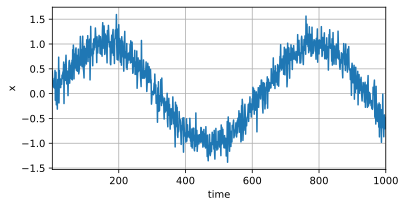

In [2]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = np.arange(1, T + 1, dtype=np.float32)
        self.x = np.sin(0.01 * self.time) + np.random.randn(T) * 0.2
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

From this sequence we extract training examples,
each consisting of features and a label.

To begin, we try a model that acts as though
the data satisfied a $\tau$-order Markov condition,
and thus predicts $x_t$ using only the past $\tau$ observations.
[**Thus for each timestep we have an example
with label $y  = x_t$ and features
$\mathbf{x}_t = [x_{t-\tau}, \ldots, x_{t-1}]$.**]
The astute reader might have noticed that
this results in 1000-$\tau$ examples,
since we lack sufficient history for $y_1, \ldots, y_\tau$.
While we could pad the first $\tau$ sequences with zeros,
to keep things simple, we drop them for now.
The resulting dataset contains $T - \tau$ examples,
where each input to the model has sequence length $\tau$.
We (**create a data iterator on the first 600 examples**),
covering a period of the sin function.


In [3]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T-self.tau+i] for i in range(self.tau)]
    self.features = np.stack(features, 1)
    self.labels = self.x[self.tau:].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

In this example our model will be a standard linear regression.


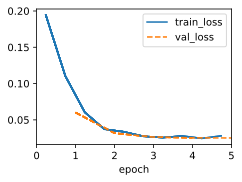

In [4]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

## Prediction

[**To evaluate our model, we first check
How well our model performs at one-step-ahead prediction**].


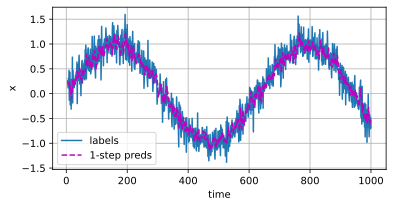

In [5]:
onestep_preds = model(data.features).asnumpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x',
         legend=['labels', '1-step preds'], figsize=(6, 3))

The one-step-ahead predictions look good.
even near the end $t=1000$.

Now consider, what if we only observe sequence data
up until time step 604 (`n_train + tau`)
but wished to make predictions several steps
into the future.
Unfortunately, we cannot directly compute
the one-step-ahead prediction for time step 609,
because we do not know the corresponding inputs,
having seen only up to $x_{604}$.
We can address this problem by plugging in
our earlier predictions as inputs to our model
for making subsequent predictions,
projecting forward, one step at a time,
until reaching the desired sequence step:

$$
\hat{x}_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \\
\hat{x}_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \\
\hat{x}_{607} = f(x_{603}, x_{604}, \hat{x}_{605}, \hat{x}_{606}),\\
\hat{x}_{608} = f(x_{604}, \hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}),\\
\hat{x}_{609} = f(\hat{x}_{605}, \hat{x}_{606}, \hat{x}_{607}, \hat{x}_{608}),\\
\ldots
$$

Generally, for an observed sequence $x_1, \ldots, x_t$,
its predicted output $\hat{x}_{t+k}$ at time step $t+k$
is called the $k$*-step-ahead prediction*.
Since we have observed up to $x_{604}$,
its $k$-step-ahead prediction is $\hat{x}_{604+k}$.
In other words, we will have to
keep on using our own predictions
to make multistep-ahead predictions.
Let's see how well this goes.


In [6]:
multistep_preds = np.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1)))
multistep_preds = multistep_preds.asnumpy()

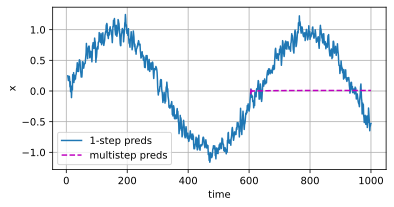

In [7]:
d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'], figsize=(6, 3))

Unfortunately, in this case we fail spectacularly.
The predictions decay to a constant
pretty quickly after a few prediction steps.
Why did the algorithm perform so much worse
when predicting further into the future?
Ultimately, this owes to the fact
that errors build up.
Let's say that after step 1 we have some error $\epsilon_1 = \bar\epsilon$.
Now the *input* for step 2 is perturbed by $\epsilon_1$,
hence we suffer some error in the order of
$\epsilon_2 = \bar\epsilon + c \epsilon_1$
for some constant $c$, and so on.
The predictions can diverge rapidly
from the true observations.
You may already be familiar
with this common phenomenon.
For instance, weather forecasts for the next 24 hours
tend to be pretty accurate but beyond that,
accuracy declines rapidly.
We will discuss methods for improving this
throughout this chapter and beyond.

Let's [**take a closer look at the difficulties in $k$-step-ahead predictions**]
by computing predictions on the entire sequence for $k = 1, 4, 16, 64$.


In [8]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(np.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau:]

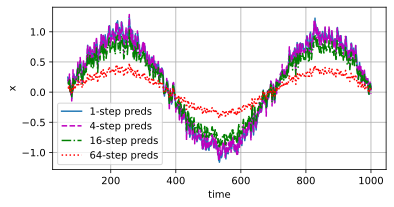

In [9]:
steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].asnumpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))

This clearly illustrates how the quality of the prediction changes
as we try to predict further into the future.
While the 4-step-ahead predictions still look good,
anything beyond that is almost useless.

## Summary

* There is quite a difference in difficulty
  between interpolation and extrapolation.
  Consequently, if you have a sequence, always respect
  the temporal order of the data when training,
  i.e., never train on future data.
* Sequence models require specialized statistical tools for estimation.
  Two popular choices are autoregressive models
  and latent-variable autoregressive models.
* For causal models (e.g., time going forward),
  estimating the forward direction is typically
  a lot easier than the reverse direction.
* For an observed sequence up to time step $t$,
  its predicted output at time step $t+k$
  is the $k$*-step-ahead prediction*.
  As we predict further in time by increasing $k$,
  the errors accumulate and the quality of the prediction degrades,
  often dramatically.

## Exercises

1. Improve the model in the experiment of this section.
    1. Incorporate more than the past 4 observations? How many do you really need?
    1. How many past observations would you need if there was no noise? Hint: you can write $\sin$ and $\cos$ as a differential equation.
    1. Can you incorporate older observations while keeping the total number of features constant? Does this improve accuracy? Why?
    1. Change the neural network architecture and evaluate the performance. You may train the new model with more epochs. What do you observe?
1. An investor wants to find a good security to buy.
   He looks at past returns to decide which one is likely to do well.
   What could possibly go wrong with this strategy?
1. Does causality also apply to text? To which extent?
1. Give an example for when a latent autoregressive model
   might be needed to capture the dynamic of the data.


[Discussions](https://discuss.d2l.ai/t/113)
